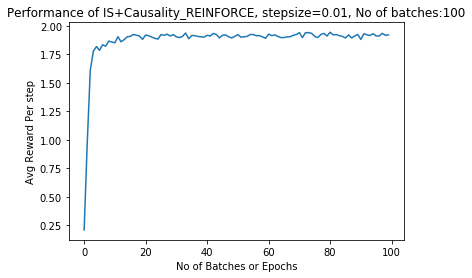

In [2]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import gym_envs
import random
from random import choices
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('grid_world-v0')
M = env.action_space.n
N1 = env.state_space.n
breakout = True
N = N1*N1
k = 0
d = {}
for i in range(N1):
    for j in range(N1):
        d.update([((i,j),k)])
        k+=1

theta = np.zeros((M,N))
rew = np.ones((M,N))

alpha = 0.01
ep_max = 100
epsilon = 0
t_steps = 30
p = np.zeros((M,N))
dist = [epsilon, 1-epsilon]
choice = [1,2]
choice_a = [0,1,2,3]

def softmax(s,policy_g):
    
    #p_theta = np.exp(np.multiply(theta[:,s],rew[:,s]))
    p_theta = np.exp(policy_g[:,s])
    #print(np.linalg.norm(theta))
    return p_theta/np.sum(p_theta), np.argmax(p_theta/np.sum(p_theta))

count= 0

def softmax_complete():
    P_Theta = np.zeros((M,N))
    for i in range(N):
        p_theta = np.exp(np.multiply(theta[:,i],rew[:,i]))
        p_theta = p_theta/np.sum(p_theta)
        P_Theta[:,i] = p_theta
        #print(np.multiply(theta[:,s],rew[:,s]))
        #print(rew[:,s])
    print('Finally:', P_Theta)
    #tmp = np.argmax(P_Theta,axis=0)
    tmp_star = np.zeros((N1,N1))
    for i in range(N1):
        for j in range(N1):
            s = d[(i,j)]
            f1 = np.argmax(P_Theta[:,s])
            tmp_star[4-i,j] = f1
    #print(tmp_star)
    
rew_p_st = np.zeros(100)
iteration = np.zeros_like(rew_p_st)    
for j in range(100):
    
    tt = theta
    p_arr_old = np.zeros(t_steps)
    p_arr_new = np.zeros(t_steps)
    p_ratio = np.zeros(t_steps) 
    policy_new = theta
    for i in range(ep_max):
        
        grd = np.zeros((t_steps,M,N))
        env.reset()
        s1,s2 = env.state
        s_arr = np.zeros(t_steps+1, dtype=np.int8) # to store the sequence of states in T steps
        a_arr = np.zeros(t_steps+1, dtype=np.int8) # to store the sequence of actions in T steps
        r_arr = np.zeros(t_steps+1) # to store the sequence of rewards in T steps.
        s_arr[0] = d[(s1,s2)]


          
        for t in range(t_steps):
#                
            tmp1, tmp2  = softmax(s_arr[t],theta)
            tmp3 = [tmp1[0], tmp1[1], tmp1[2], tmp1[3]]
            tmp = random.choices(choice_a, tmp3)
            a_arr[t] = int(tmp[0])
            p_arr_old[t] = tmp3[a_arr[t]]
            tmp4,tmp5 = softmax(s_arr[t],policy_new)
            p_arr_new[t] = tmp4[a_arr[t]]
            p_ratio[t] = p_arr_new[t]/p_arr_old[t]
            
            obs, reward, done, info = env.step(a_arr[t])
            rew_p_st[j] = rew_p_st[j] + reward
            s1,s2 = obs
            s_arr[t+1] = d[(s1,s2)]
            r_arr[t+1] = reward
            phi = np.zeros((M,N))
           
            phi[a_arr[t],s_arr[t]] = 1
            grd[t,:,:] += phi 
            p_theta, a_arr[t] = softmax(s_arr[t],theta)
            
            for ac in range(M):
                phi = np.zeros((M,N))
                phi[ac,s_arr[t]] = 1
                grd[t,:,:] -= p_theta[ac]*phi
            
        theta = policy_new
        sum1 = np.zeros_like(theta)
        for t in range(t_steps):
            v_t = 0
            for t1 in range(t+1, t_steps+1):
                v_t += r_arr[t1]
            delta = v_t
            sum1 += alpha*delta*(grd[t,:,:])
  
        policy_new += np.prod(p_ratio)*sum1

    
    rew_p_st[j] = rew_p_st[j]/(ep_max*t_steps)
    iteration[j] = j

     
    #print('Count is: ', j)
    
#softmax_complete()
        
    
    #softmax_complete()
#Plot
plt.plot(iteration,rew_p_st)
plt.xlabel('No of Batches or Epochs')
plt.ylabel('Avg Reward Per step')
plt.title('Performance of IS+Causality_REINFORCE, stepsize=0.01, No of batches:100')
plt.show()

In [3]:
import pandas as pd

df = pd.read_csv('AblationStudy_Final.csv')
df['CA_IS_REINFORCE_reward'] = rew_p_st
df.to_csv('AblationStudy_Final.csv')